In [1]:
import tensorflow as tf
from tensorflow.keras import layers

import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
from sklearn import preprocessing
import tensorflow as tf
import csv
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Conv2D, MaxPool2D, Flatten, Input, Concatenate, Lambda, experimental
from tensorflow.keras.optimizers import SGD
from  tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from tensorflow import keras
from PIL import Image, ImageOps, ImageDraw
import os, glob
import numpy as np
from keras_tuner.tuners import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters
import pandas as pd
import sklearn
import math
import random
import matplotlib.pyplot as plt
import cv2



#  Definir Tamanhos

In [164]:
processing = False
grayscale = True
g = 1
s = 3

if(grayscale == True):
    g = 0
    s = 1

#Se fizer load em RGB (1)
#Se fizer load em Grayscale (0)

h = 500
w = int(500*1.3)
size = (w,h)
input = (h,w,1)

# Cria arrays com imagens

In [165]:
train_path = "D:/Tese/Projeto BALCAT/Imagens/NIST CARTS/NIST Cartridges/Train"
labels = os.listdir(train_path)

def gammaCorrection(src, gamma):
    invGamma = 1 / gamma
 
    table = [((i / 255) ** invGamma) * 255 for i in range(256)]
    table = np.array(table, np.uint8)
 
    return cv2.LUT(src, table)

def create_lists(type):
    train_path = "D:/Tese/Projeto BALCAT/Imagens/NIST CARTS/NIST Cartridges/Train"
    labels = os.listdir(train_path)

    #Converte labels em labels binários 
    lb = preprocessing.LabelBinarizer()
    bin_lab = lb.fit_transform(labels)
    path = "D:/Tese/Projeto BALCAT/Imagens/NIST CARTS/NIST Cartridges/" + type

    image_set = []
    b_labels_set = []
    i_labels_set = []

    #Cria train_set e train_labels
    for i,b in zip(labels, bin_lab): 
        class_path = path + "/" + i

        carts = os.listdir(class_path)
        for cart in carts:
            img = cv2.imread(class_path +  "/" + cart, g)
            img = cv2.resize(img, size, interpolation=cv2.INTER_CUBIC)
            if processing == True:
                img = cv2.equalizeHist(img)
                #img = cv2.medianBlur(img, 5)
                #gamma_c = gammaCorrection(img, 2)
                #(T, img) = cv2.threshold(gamma_c, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
            img = np.reshape(img, input)
            image_set.append(img/255)
            b_labels_set.append(b)
            i_labels_set.append(i)

    #Faz shuffle às listas de forma igual
    c = list(zip(image_set, b_labels_set, i_labels_set))
    random.shuffle(c)
    image_set, b_labels_set, i_labels_set = zip(*c)
    return np.array(image_set), np.array(b_labels_set), np.array(i_labels_set)

#Train set e labels em forma de numpy array
train_set, train_labels, s_train_labels = create_lists("Train")

val_set, val_labels, s_val_labels = create_lists("Validation")

test_set, test_labels, s_test_labels = create_lists("Test")



# Cria DF para image Generator

In [ ]:
train_path = "D:/Tese/Projeto BALCAT/Imagens/NIST CARTS/NIST Cartridges/Train"
labels = os.listdir(train_path)

#Converte labels em labels binários 
lb = preprocessing.LabelBinarizer()
bin_lab = lb.fit_transform(labels)


df = pd.DataFrame([], columns=['path', 'label'])
df.head()

#Vai acrescentando filepath e label ao dataframe
for i,b in zip(labels, bin_lab): 
    class_path = train_path + "/" + i
    carts = os.listdir(class_path)
    for cart in carts:
        df_l = pd.DataFrame({"path": [class_path + "/" + cart], "label": [i]})
        df = df.append(df_l, ignore_index=True)


#shuffle dataframe
df = pd.concat([df[:1], df[1:].sample(frac=1)]).reset_index(drop=True)



# Cria os geradors com data augmentation (comentado)

In [166]:

def create_gen():
    # Load the Images with a generator and Data Augmentation
    train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
        validation_split=0.2
    )



    train_images = train_generator.flow(

        x_col='path',
        y_col='label',
        target_size=size,
        color_mode='grayscale',
        class_mode='categorical',
        batch_size=128,
        shuffle=True,
        seed=0,
        subset='training',
        # rotation_range=30, # Uncomment to use data augmentation
        # zoom_range=0.15,
        # width_shift_range=0.2,
        # height_shift_range=0.2,
        # shear_range=0.15,
        # horizontal_flip=True,
        # fill_mode="nearest"
    )

    val_images = train_generator.flow_from_dataframe(
        dataframe=df,
        x_col='path',
        y_col='label',
        target_size=size,
        color_mode='grayscale',
        class_mode='categorical',
        batch_size=128,
        shuffle=True,
        seed=0,
        subset='validation'
        # rotation_range=30, # Uncomment to use data augmentation
        # zoom_range=0.15,
        # width_shift_range=0.2,
        # height_shift_range=0.2,
        # shear_range=0.15,
        # horizontal_flip=True,
        # fill_mode="nearest"
    )

    # test_images = test_generator.flow_from_dataframe(
    #     dataframe=test_df,
    #     x_col='Filepath',
    #     y_col='Label',
    #     target_size=(224, 224),
    #     color_mode='rgb',
    #     class_mode='categorical',
    #     batch_size=32,
    #     shuffle=False
    # )
    
    return train_generator,train_images,val_images


datagen = ImageDataGenerator(
    rotation_range=20,
    horizontal_flip=True,
    vertical_flip=False

)
# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
datagen.fit(train_set)
# fits the model on batches with real-time data augmentation:

In [ ]:
train_generator,train_images,val_image = create_gen()

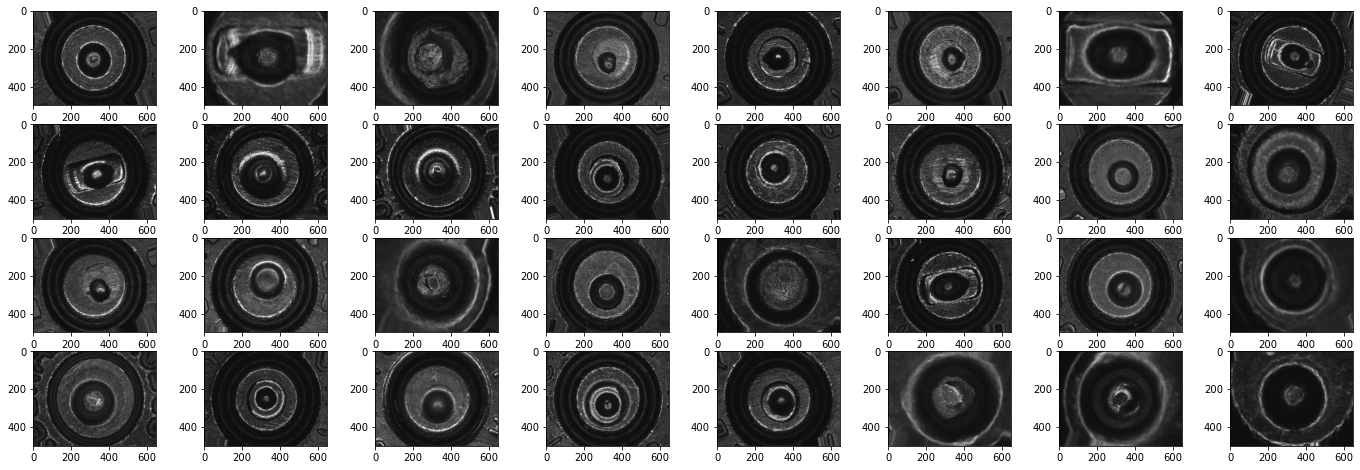

In [167]:
images = datagen.flow(train_set, train_labels, batch_size=32)[0][0]

w = 10
h = 10
fig = plt.figure(figsize=(24, 8))
columns = 8
rows = 4
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(cv2.cvtColor(images[i-1], cv2.COLOR_BGR2RGB))
plt.show()

# Criaçao de modelo normal

In [172]:
def create_model():
    model = Sequential()
    model.add(Conv2D(64, (5, 5), activation='relu', input_shape=input))
    model.add(MaxPool2D(5, 5))
    model.add(Conv2D(64, (4, 4), activation='relu', input_shape=input))
    model.add(Conv2D(36, (3, 3), activation='relu', input_shape=input))
    model.add(MaxPool2D(4, 4))
    model.add(Conv2D(36, (3, 3), activation='relu', input_shape=input))
    model.add(MaxPool2D(4, 4))
    model.add(Conv2D(36, (3, 3), activation='relu', input_shape=input))
    model.add(Conv2D(36, (3, 3), activation='relu', input_shape=input))
    model.add(Flatten())
    model.add(tf.keras.layers.Dense(128, activation="relu"))
    model.add(tf.keras.layers.Dense(5, activation="softmax"))
    model.compile(loss = "categorical_crossentropy", optimizer= "Adam", metrics=["accuracy"])

    return model

def create_model_hp(hp):
    model = Sequential()
    
    filter_size =  hp.Int("filter_0", 2,6)
    model.add(Conv2D(hp.Int("conv_0_units", 4, 64, 16), (filter_size, filter_size), activation='relu', input_shape=input))
    pool_size =  hp.Int("pool_" + str(1), 1, 4)
    model.add(MaxPool2D(pool_size, pool_size))
    for i in range(hp.Int("n_layers", 1,3)):
        filter_size =  hp.Int("filter_" + str(i + 1), 2, 5)
        model.add(Conv2D(hp.Int("conv_" + str(i) + "_units", 4, 64, 16), (filter_size, filter_size), activation='relu', input_shape=input))
        pool_size =  hp.Int("pool_" + str(i + 1), 1, 3)
        model.add(MaxPool2D(pool_size, pool_size))
    
    model.add(Flatten())
    for i in range(hp.Int("n_layers", 1,2)):
        fc =  hp.Int("fc", 4, 128, 16)
        model.add(tf.keras.layers.Dense(fc, activation="sigmoid"))
    model.add(tf.keras.layers.Dense(5, activation="softmax"))
    model.compile(loss = "categorical_crossentropy", optimizer= "Adam", metrics=["accuracy"])
    return model


# Criaçao de modelo com transfer learning VGG16 (precisa de input RGB)

In [ ]:
def create_tl_model():
    p_model = tf.keras.applications.vgg16.VGG16(input_shape = input, weights = "imagenet", include_top=False)
    p_model.trainable = False
    inputs = p_model.input
    x = Conv2D(32, 3, activation="relu")(inputs)
    x = MaxPool2D((4,4))(x)
    x = Conv2D(32, 3, activation="relu")(x)
    x = Conv2D(32, 3, activation="relu")(x)
    x = Flatten()(p_model.output)
    x = Dense(5, activation="relu")(x)
    model = Model(inputs, x)
    model.summary()
    model.compile(loss = "categorical_crossentropy", optimizer= "Adam", metrics=["accuracy"])
    return model

create_tl_model().summary()

In [ ]:
cnn = create_model()
cnn.fit(train_images, validation_data= val_image,epochs = 10, verbose = 1)

# Fit para modelo com array (mais rápido)

In [173]:
cnn = create_model()
cnn.fit(datagen.flow(train_set, train_labels, batch_size=4),
         validation_data=datagen.flow(val_set, val_labels,
         batch_size=32),
         steps_per_epoch=int(len(train_set)/32)-1, epochs=10)

#cnn.fit(train_set, train_labels, validation_data = (val_set, val_labels), batch_size = 128, epochs = 40, verbose = 1)

Epoch 1/10
27/27 [==============================] - ETA: 0s - loss: 1.6180 - accuracy: 0.2407

ResourceExhaustedError:  OOM when allocating tensor with shape[32,64,496,646] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node sequential_31/conv2d_124/Conv2D (defined at \AppData\Local\Temp/ipykernel_18004/886172861.py:5) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_test_function_63222]

Function call stack:
test_function


# Fitting keras tuner

In [ ]:
tuner = RandomSearch(
    create_model_hp,
    objective='val_accuracy',
    max_trials=200,  # how many model variations to test?
    executions_per_trial=3,  # how many trials per variation? (same model could perform differently)
    directory="Test_150_150")


tuner.search(train_set[:],
             train_labels[:], batch_size=16,
             verbose=1, # just slapping this here bc jupyter notebook. The console out was getting messy.
             epochs=30,
             callbacks=[tf.keras.callbacks.EarlyStopping('accuracy', patience=4)],  # if you have callbacks like tensorboard, they go here.
             validation_data=(test_set[:], test_labels[:]))


tuner.results_summary()
model = tuner.get_best_models()[0]
model.save("good_model_150_150.h5")

# Triplet Loss


In [ ]:
import umap

train_path = "D:/Tese/Projeto BALCAT/Imagens/NIST CARTS/NIST Cartridges/Train"
labels = os.listdir(train_path)

def triplet_generator(batch_size=64):
    classes = labels
    while True:
        a = []
        p = []
        n = []
        for x in range(batch_size):
            p_n = random.sample(list(classes), 2)
            pos = p_n[0]
            neg = p_n[1]
            #Select anchor and positive sample 
            positives = random.sample(list(train_set[s_train_labels == pos]), 2)
            #Select negative sample 
            negative = random.choice(list(train_set[s_train_labels == neg]))
            a.append(positives[0])
            p.append(positives[1])
            n.append(negative)
        yield ([np.array(a),np.array(p),np.array(n)], np.zeros((batch_size,1)).astype("float32"))

def triplet_generator_test(batch_size=100):
    classes = labels
    a = []
    p = []
    n = []
    for x in range(batch_size):
        p_n = random.sample(list(classes), 2)
        pos = p_n[0]
        neg = p_n[1]
        #Select anchor and positive sample 
        positives = random.sample(list(test_set[s_test_labels == pos]), 2)
        #Select negative sample 
        negative = random.choice(list(test_set[s_test_labels == neg]))
        a.append(positives[0])
        p.append(positives[1])
        n.append(negative)
    return ([np.array(a),np.array(p),np.array(n)], np.zeros((batch_size,1)).astype("float32"))

def triplet_loss(y_true, y_pred):
    anchor_out = y_pred[:,0:50] 
    positive_out = y_pred[:,50:100] 
    negative_out = y_pred[:,100:150] 

    pos_dist = K.sum(K.abs(anchor_out - positive_out), axis = 1)
    neg_dist = K.sum(K.abs(anchor_out - negative_out), axis = 1)

    probs = K.softmax([pos_dist, neg_dist], axis = 0)

    return K.mean(K.abs(probs[0]) + K.abs(1.0 - probs[1]))



def accuracy():
    correct = 0
    val_coords =  trip_model.layers[3].predict(np.array(val_set))
    test_coords = trip_model.layers[3].predict(np.array(test_set))
    for i,l in zip(val_coords, s_val_labels):
        distances = []
        coord = i
        for j in labels:
            model_imgs = list(test_coords[s_test_labels == j])
            dist = 0
            for gun_img in model_imgs:
                dist += np.linalg.norm(coord - gun_img)
            dist = dist/len(model_imgs)
            distances.append(dist)
        print(distances)
        label_p = distances.index(min(distances))
        label_a = list(labels).index(l)

        if(label_a==label_p): 
            correct+=1
    
    return correct/len(val_coords)

inputs = Input(input)
x = Conv2D(32, (3,3), activation="relu")(inputs)
x = MaxPool2D((3,3))(x)
x = Conv2D(32, (3,3), activation="relu")(x)
x = Conv2D(32, (3,3), activation="relu")(x)
x = Conv2D(32, (3,3), activation="relu")(x)
x = MaxPool2D((3,3))(x)
x = Flatten()(x)
x = Dense(50, activation="relu")(x)

model = Model(inputs, x)
model.summary()

trip_a = Input(input) 
trip_p = Input(input) 
trip_n = Input(input) 

trip_out = Concatenate()([model(trip_a), model(trip_p), model(trip_n)])
trip_model = Model([trip_a, trip_p, trip_n], trip_out)

trip_model.summary()

trip_model.compile(loss=triplet_loss, optimizer="adam")

testing = triplet_generator_test(100)

trip_model.fit(triplet_generator(), validation_data = testing, steps_per_epoch = 100, epochs = 3)

accuracy()


In [ ]:
import umap

label_encoder = preprocessing.LabelEncoder()
test_lab = label_encoder.fit_transform(s_test_labels)

embbedings=trip_model.layers[3].predict(test_set, verbose = 1)
embbedings_t=trip_model.layers[3].predict(train_set, verbose = 1)

embbedings_reduced = umap.UMAP(n_neighbors = 15, min_dist = 0.3, metric="correlation").fit_transform(embbedings)
embbedings_reduced_t = umap.UMAP(n_neighbors = 15, min_dist = 0.3, metric="correlation").fit_transform(embbedings_t)

plt.scatter(embbedings_reduced[:,0], embbedings_reduced[:,1], c=test_lab)

In [ ]:
label_encoder = preprocessing.LabelEncoder()
test_lab = label_encoder.fit_transform(s_train_labels)

embbedings=trip_model.layers[3].predict(test_set, verbose = 1)
embbedings_t=trip_model.layers[3].predict(train_set, verbose = 1)

embbedings_reduced = umap.UMAP(n_neighbors = 15, min_dist = 0.3, metric="correlation").fit_transform(embbedings)
embbedings_reduced_t = umap.UMAP(n_neighbors = 15, min_dist = 0.3, metric="correlation").fit_transform(embbedings_t)

plt.scatter(embbedings_reduced_t[:,0], embbedings_reduced_t[:,1], c=test_lab)

# Siamese NN

In [ ]:
def pair_generator(img_list, label_list, batch_size=100):
    classes = labels
    a = []
    p = []
    n = []
    for x in range(int(batch_size/2)):
        p_n = random.sample(list(classes), 2)
        pos = p_n[0]
        neg = p_n[1]
        #Select anchor and positive sample 
        positives = random.sample(list(img_list[label_list == pos]), 2)
        #Select negative sample 
        negative = random.choice(list(img_list[label_list == neg]))
        a.append(positives[0])
        p.append(positives[1])
        n.append(negative)
    
    pairs = [[x, y] for x, y in zip(a, p)]
    [pairs.append([y, x]) for x, y in zip(a, n)]
    print(pairs)
    pairs_labels = list(np.ones((len(p))))
    pairs_labels.extend(np.zeros((len(n))))
    pairs, pairs_labels= shuffle(pairs, pairs_labels)
    
    return np.asarray(pairs), np.asarray(pairs_labels, dtype=np.int32)



def batch_pair_generator(batch_size=32):
    classes = labels
    while True:
        a = []
        p = []
        n = []
        pairs=[]
        for x in range(int(batch_size/2)):
            p_n = random.sample(list(classes), 2)
            pos = p_n[0]
            neg = p_n[1]
            #Select anchor and positive sample 
            positives = random.sample(list(train_set[s_train_labels == pos]), 2)
            #Select negative sample 
            negative = random.choice(list(train_set[s_train_labels == neg]))
            a.append(positives[0])
            p.append(positives[1])
            n.append(negative)
        
        pairs = [[x, y] for x, y in zip(a, p)]
        [pairs.append([y, x]) for x, y in zip(a, n)]
        pairs_labels = list(np.ones((len(p))))
        pairs_labels.extend(np.zeros((len(n))))
        pairs, pairs_labels= shuffle(pairs, pairs_labels)
        pairs, pairs_labels = np.array(pairs), np.array(pairs_labels)
        yield ([pairs[:,0], pairs[:,1]],pairs_labels[:])

# train_pairs, train_label_pairs = pair_generator(train_set, s_train_labels, batch_size=1500)
test_pairs, test_label_pairs = pair_generator(test_set, s_test_labels, batch_size=200)
# print(train_pairs.shape)

In [ ]:
def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))
    
def get_siamese_model(hp):
    #two input images 
    left_input = Input(input)
    right_input = Input(input)
    
    # Convolutional Neural Network to extract feature vector
    model = Sequential()
    
    filter_size =  hp.Int("filter_0", 2,6)
    model.add(Conv2D(hp.Int("conv_0_units", 4, 64, 16), (filter_size, filter_size), activation='relu', input_shape=input))
    model.add(MaxPool2D(3, 3))
    for i in range(hp.Int("n_layers", 0,3)):
        filter_size =  hp.Int("filter_" + str(i + 1), 1, 6)
        model.add(Conv2D(hp.Int("conv_" + str(i) + "_units", 4, 64, 16), (filter_size, filter_size), activation='relu'))
        pool_size =  hp.Int("pool_" + str(i + 1), 1, 3)
        model.add(MaxPool2D(pool_size, pool_size))
    
    model.add(Flatten())
    model.add(tf.keras.layers.Dense(128, activation="sigmoid"))

    # feature vectors for each image of the pair
    encoded_l = model(left_input)
    encoded_r = model(right_input)


    # absolute difference between the feature vectors
    L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([encoded_l, encoded_r])
    #L1_distance = euclidean_distance([encoded_l, encoded_r])
    
    # sigmoid layer to predict similarity 
    prediction = Dense(1,activation='sigmoid')(L1_distance)
    
    # connect inputs with outputs
    siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)
    
    siamese_net.compile(loss = "binary_crossentropy", optimizer= "Adam", metrics=["accuracy"])


    return siamese_net

def get_siamese_model_tl(hp):
    #two input images 
    left_input = Input(input)
    right_input = Input(input)
    
    # Convolutional Neural Network to extract feature vector
    model = Sequential()

    p_model = tf.keras.applications.vgg16.VGG16(input_shape = input, weights = "imagenet", include_top=False)
    p_model.trainable = False
    inputs = p_model.input

    filter_size =  hp.Int("filter_0", 2,4)
    x = Conv2D(hp.Int("conv_0_units", 4, 64, 16), (filter_size, filter_size), activation='relu')(inputs)
    x = MaxPool2D(2, 2)(x)
    for i in range(hp.Int("n_layers", 0,1)):
        filter_size =  hp.Int("filter_" + str(i + 1), 1, 3)
        x = Conv2D(hp.Int("conv_" + str(i) + "_units", 4, 64, 16), (filter_size, filter_size), activation='relu')(x)
        pool_size =  hp.Int("pool_" + str(i + 1), 1, 2)
        x = MaxPool2D(pool_size, pool_size)(x)

    x = Flatten()(p_model.output)
    x = tf.keras.layers.Dense(128, activation="sigmoid")(x)
    model = Model(inputs, x)


    # feature vectors for each image of the pair
    encoded_l = model(left_input)
    encoded_r = model(right_input)


    # absolute difference between the feature vectors
    L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([encoded_l, encoded_r])
    #L1_distance = euclidean_distance([encoded_l, encoded_r])
    
    # sigmoid layer to predict similarity 
    prediction = Dense(1,activation='sigmoid')(L1_distance)
    
    # connect inputs with outputs
    siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)
    
    siamese_net.compile(loss = "binary_crossentropy", optimizer= "Adam", metrics=["accuracy"])


    return siamese_net



tuner = RandomSearch(
    get_siamese_model_tl,
    objective='val_accuracy',
    max_trials=30,  # how many model variations to test?
    executions_per_trial=1,  # how many trials per variation? (same model could perform differently)
    directory="50_50")


tuner.search(batch_pair_generator(), steps_per_epoch = 20,
             verbose=1, # just slapping this here bc jupyter notebook. The console out was getting messy.
             epochs=15,
             callbacks=[tf.keras.callbacks.EarlyStopping('accuracy', patience=4)],  # if you have callbacks like tensorboard, they go here.
             validation_data=([test_pairs[:,0], test_pairs[:,1]], test_label_pairs[:]))


tuner.results_summary()
model = tuner.get_best_models()[0]
model.save("good_model_50_50.h5")

# Accuracy using distances

In [ ]:

#model = tf.keras.models.load_model('siamese83_80_80.h5')
tuner.results_summary()
model = tuner.get_best_models()[0]

model = model.get_layer("sequential")

model.save("85_150_150.h5")

def accuracy():
    correct = 0
    val_coords =  model.predict(np.array(val_set))
    test_coords = model.predict(np.array(train_set))
    for i,l in zip(val_coords, s_val_labels):
        distances = []
        coord = i
        for j in labels:
            model_imgs = list(test_coords[s_train_labels == j])
            dist = 0
            for gun_img in model_imgs:
                dist += np.linalg.norm(coord - gun_img)
            dist = dist/len(model_imgs)
            distances.append(dist)
        print(distances)
        label_p = distances.index(min(distances))
        label_a = list(labels).index(l)

        if(label_a==label_p): 
            correct+=1
    
    return correct/len(val_coords)
accuracy()


In [ ]:
#Further train the best network
model = tf.keras.models.load_model('siamese83_80_80.h5')

#Faz reset ao modelo (elimina os pesos)
model = tf.keras.models.clone_model(model)
model.compile(loss = "binary_crossentropy", optimizer= "ADAM", metrics=["accuracy"])


model.fit(batch_pair_generator(), steps_per_epoch = 100,
verbose=1, # just slapping this here bc jupyter notebook. The console out was getting messy.
            epochs=15,
            validation_data=([test_pairs[:,0], test_pairs[:,1]], test_label_pairs[:])
         )

In [ ]:
from sklearn.model_selection import train_test_split

X_train = model.predict(train_set)
X_test = model.predict(test_set)
y_train = s_train_labels
y_test = s_test_labels

# Random forest on top of SNN

In [ ]:

#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=10)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)

#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

# SVM on top of SNN

In [ ]:
#Import svm model
from sklearn import svm

#Create a svm Classifier
clf = svm.SVC(kernel='linear') # Linear Kernel

#Train the model using the training sets
clf.fit(X_train, y_train)

#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

#Predict the response for test dataset
y_pred = clf.predict(X_test)

# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))


# KNN on top SNN

In [ ]:
from sklearn import preprocessing
#creating labelEncoder
le = preprocessing.LabelEncoder()
# Converting string labels into numbers.
labels_encoded=le.fit_transform(s_test_labels)

X_train, X_test, y_train, y_test = train_test_split(model.predict(test_set), labels_encoded, test_size=0.2)

from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=3)

# Train the model using the training sets
knn.fit(X_train,y_train)

#Predict Output
predicted= knn.predict(X_test) 
print(predicted)

# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, predicted))

In [ ]:
from sklearn import preprocessing
#creating labelEncoder
le = preprocessing.LabelEncoder()
# Converting string labels into numbers.
labels_encoded=le.fit_transform(s_val_labels)

X_test = model.predict(val_set)
y_test = labels_encoded
# 
#Predict Output
predicted= knn.predict(X_test) 
print(predicted)

# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, predicted))